# PCPseAAC分组问题

In [1]:
import sys
sys.path.append("src")
import os
import json

import libpybiofeature

import utils
work_Dir = utils.workdir.workdir(os.getcwd(), 4)

import numpy as np
import pandas as pd

from Bio import SeqIO

In [30]:
def load_PCPseAAC_feature(TxSE_args: dict):

    # Extract Feature
    seq_id_dict = None
    with open(TxSE_args['seq_id'], 'r', encoding='UTF-8') as f:
        seq_id_dict = json.load(f)

    def read_data(
        path_to_csv: str,
        path_to_fasta: str,
    ):
        df = pd.read_csv(path_to_csv, index_col=None, header=None)
        df.index = [
            seq.id for seq in SeqIO.parse(path_to_fasta, "fasta")
        ]
        df.columns = list("ACDEFGHIKLMNPQRSTVWY") + [
            str(i) for i in range(1, (df.shape[1] - 20) + 1)
        ]
        return df

    # PCPseAAC
    PCPseAAC_feature = {
        "name": "PCPseAAC",
        "t_p": read_data(
            path_to_csv=TxSE_args['PCPseAAC']['t']['p'],
            path_to_fasta=TxSE_args['fasta']['t']['p'],
        ),
        "t_n": read_data(
            path_to_csv=TxSE_args['PCPseAAC']['t']['n'],
            path_to_fasta=TxSE_args['fasta']['t']['n'],
        ),
        "v_p": read_data(
            path_to_csv=TxSE_args['PCPseAAC']['v']['p'],
            path_to_fasta=TxSE_args['fasta']['v']['p'],
        ),
        "v_n": read_data(
            path_to_csv=TxSE_args['PCPseAAC']['v']['n'],
            path_to_fasta=TxSE_args['fasta']['v']['n'],
        ),
    }

    PCPseAAC_feature['p'] = pd.concat([
        PCPseAAC_feature['t_p'],
        PCPseAAC_feature['v_p'],
    ])
    PCPseAAC_feature['n'] = pd.concat([
        PCPseAAC_feature['t_n'],
        PCPseAAC_feature['v_n'],
    ])

    return PCPseAAC_feature

In [31]:
prot_type = 1
cter_bool = True
Tx_arg = {
    "type": f'T{prot_type}',
    'seq_id': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 'seq_id.json']),
    "PCPseAAC": {
        't': {
            'p': os.path.join(work_Dir, *['out/libfeatureselection/PCPseAAC/data/t_p.csv', ]),
            'n': os.path.join(work_Dir, *['out/libfeatureselection/PCPseAAC/data/t_n.csv', ])
        },
        'v': {
            'p': os.path.join(work_Dir, *['out/libfeatureselection/PCPseAAC/data/v_p.csv', ]),
            'n': os.path.join(work_Dir, *['out/libfeatureselection/PCPseAAC/data/v_n.csv', ])
        },
    },
    'fasta': {
        'cter': cter_bool,
        't': {
            'p': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 't_p.fasta']),
            'n': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 't_n.fasta'])
        },
        'v': {
            'p': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 'v_p.fasta']),
            'n': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 'v_n.fasta'])
        },
    },
}
save_dir = "out/libfeatureselection/PCPseAAC/origin/"

In [32]:
aac_data = load_PCPseAAC_feature(
    TxSE_args=Tx_arg
)
columns_type = list(aac_data['p'].columns)

In [33]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.use14corefonts'] = False
# mpl.rcParams['pdf.usecorefonts'] = True
mpl.rcParams['pdf.compression'] = 9

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'nature'])

from matplotlib.ticker import MaxNLocator

import seaborn as sns

In [34]:
aac_data_transformed = pd.concat([aac_data['p'], aac_data['n']], keys=['T1SP', 'non-T1SP']).reset_index(level=0).rename({
    "level_0": "Type"
}, axis=1, inplace=False).melt(id_vars="Type", value_vars=columns_type, ignore_index=False).rename({
    "variable": "Column",
    "value": "PC-PseAAC"
}, axis=1, inplace=False)
aac_data_transformed

,Type,Column,PC-PseAAC
AEI83416.1,T1SP,A,0.037562
FAA01213.1,T1SP,A,0.211314
sp|P22542.1|HSTI_ECOLX,T1SP,A,0.088276
BAB77791.1,T1SP,A,0.041078
sp|Q54450.1|HASA_SERMA,T1SP,A,0.053222
...,...,...,...
lcl|NC_008254.1_prot_WP_011581228.1_1923,non-T1SP,1,0.514412
lcl|NZ_CP006003.1_prot_WP_046715225.1_6146,non-T1SP,1,0.505877
lcl|NC_017030.1_prot_WP_014398783.1_5946,non-T1SP,1,0.489150
lcl|NZ_CP006003.1_prot_WP_046715487.1_6476,non-T1SP,1,0.550092


In [35]:
def get_star(p:float):
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return ""
from scipy.stats import wilcoxon
grouped = aac_data_transformed.groupby("Column")
wilcoxon_result = {}
for name, group in grouped:
    x = group[group['Type'] == 'T1SP']['PC-PseAAC']
    y = group[group['Type'] == 'non-T1SP']['PC-PseAAC']
    stat, p = wilcoxon(x, y)
    wilcoxon_result[name] = {
        "statistic": stat,
        "p-value": p
    }
    # print(f'Type: {name}, Wilcoxon rank-sum statistic: {stat:.2f}, p-value: {p:.3f}')
with open(f"{save_dir}/wilcoxon_result.json", "w+", encoding="UTF-8") as f:
    json.dump(wilcoxon_result, f)
aac_data_transformed.to_csv(f"{save_dir}/aac_data_transformed.csv", index_label="Seq_ID")

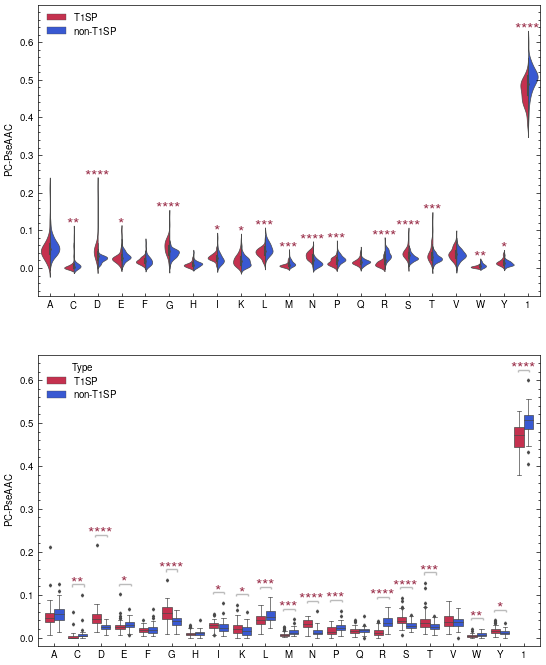

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(19.2 / 4 * 1.35, 10.8 / 3.5 * 2 * 1.35))

sns.violinplot(
    data=aac_data_transformed,
    x="Column",
    y="PC-PseAAC",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1
)
ax1.set_ylim([aac_data_transformed['PC-PseAAC'].min() - 0.075, aac_data_transformed['PC-PseAAC'].max() + 0.1])
ax_xticklabel_origin = ax1.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1.tick_params(axis='x', length=2, top=False)
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1.set_xlabel("")
ax1.legend(loc='upper left')


for i, (violin_1, violin_2) in enumerate(zip(ax1.collections[0::3], ax1.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

sns.boxplot(
    data=aac_data_transformed,
    x="Column",
    y="PC-PseAAC",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2
)
ax2.set_ylim([aac_data_transformed['PC-PseAAC'].min() - 0.02, aac_data_transformed['PC-PseAAC'].max() + 0.06])
ax_xticklabel_origin = ax2.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2.tick_params(axis='x', length=2, top=False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(aac_data_transformed[aac_data_transformed["Column"] == aa]['PC-PseAAC']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# plt.title("AAC Training-Testing Wilcoxon Signed Ranks Test")
plt.savefig(f"{save_dir}/diff.pdf", bbox_inches='tight')
plt.show()